In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

### Load datasets

In [3]:
train = pd.read_csv('./train.csv', index_col = "id")
test = pd.read_csv("./test.csv", index_col = "id")
sub = pd.read_csv("./submission.csv")

## Handle missing values

In [4]:
train_df = train.copy()
test_df = test.copy()

In [5]:
def handle_missed(df, n_freq=50):
    numeric = ['stem-width', 'stem-height', 'cap-diameter']
    category = [x for x in df.columns if x not in numeric]
    if 'class' in category:
        category.remove('class')
    # for numerical cols
    for col in numeric:
        if df[col].isnull().sum() > 0:
            mean_col = df[col].mean()
            df[col].fillna(mean_col, inplace=True)
    
    # for categorical cols
    for col in category:
        if df[col].isnull().sum() > 0:
            # Replace missing values with 'NO'
            df[col].fillna('NO', inplace=True)
            unique_vals = df[col].unique()
            freq_list = []
            freq_least = []
            for x in unique_vals:
                if np.sum(df[col] == x) > n_freq:
                    freq_list.append(x)

            # Replace less frequent values with 'LF'
            df[col] = df[col].apply(lambda x: x if x in freq_list else 'LF')
    
    return df

In [6]:
# train data
train_df = handle_missed(train_df, n_freq=80)

# test data
test_df = handle_missed(test_df, n_freq=80)

In [7]:
numeric = ['stem-width', 'stem-height', 'cap-diameter']
category = [x for x in test_df.columns if x not in numeric]
train_df[category] = train_df[category].astype('category')
test_df[category] = test_df[category].astype('category')

In [8]:
# log tranformation for nearly normal distribution of numerical columns
for col in numeric:
    train_df[col] = train_df[col].apply(lambda x: np.log(x+1.00001))

In [9]:
# log tranformation for nearly normal distribution of numerical columns
for col in numeric:
    test_df[col] = test_df[col].apply(lambda x: np.log(x+1.00001))

In [10]:
le = LabelEncoder() # converts categorical data into numerical ones: e=0, 1=p
train_df['class'] = le.fit_transform(train_df['class'])

In [11]:
X = train_df.drop(columns=['class'], axis=1)
y = train_df['class']

## XGBoost

In [12]:
from sklearn.metrics import matthews_corrcoef

def mcc_metric(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int) 
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc

## XGBoost

In [22]:
skf = StratifiedKFold(n_splits=6, random_state = 75, shuffle = True)
print(skf)
xgb_list = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    model = XGBClassifier(                                      
                        colsample_bytree=0.52,      
                        max_depth=16,             
                        min_child_weight=6,                
                        random_state=3,                 
                        n_estimators=1200, 
                        learning_rate = 0.018   ,
                        gamma = 0.002,
                        subsample = 0.7,
                        reg_alpha = 0.01,
                        reg_lambda = 1,
                        enable_categorical = True,
                        scale_pos_weight = 1,
                        device = 'cuda' ,
                        random_seed = 57
                        )

    XGB = model.fit(
    X_train,
    y_train)

    y_pred = XGB.predict(X_test)
    score = matthews_corrcoef(y_test, y_pred)
    print('MCC:', score)

    xgb_list.append(XGB)

StratifiedKFold(n_splits=6, random_state=75, shuffle=True)
MCC: 0.9848825514594146
MCC: 0.9848273630243328
MCC: 0.9851819160164508
MCC: 0.9847287799857722
MCC: 0.9849061331264822
MCC: 0.9849940301672924


## LGBM

In [32]:
from lightgbm import LGBMClassifier
skf = StratifiedKFold(n_splits=5, random_state = 57, shuffle = True)
print(skf)
lgb_list = []

params = {'verbose' : -1, 
          'objective' : 'binary', 
          'num_leaves': 512, 
          'max_depth': 10, 
          'learning_rate': 0.07, 
          'n_estimators': 1024, 
          'class_weight': 'balanced', 
          'min_child_samples': 41, 
          'subsample': 0.9, 
          'colsample_bytree': 0.72, 
          'reg_alpha': 0.07, 
          'reg_lambda': 6, 
          'random_state': 57}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

    lgb = LGBMClassifier(**params)
    lgb.fit(X_train, y_train)
    lgb_y_pred = lgb.predict(X_test)
    score = matthews_corrcoef(y_test, lgb_y_pred)
    print('MCC:', score)

    lgb_list.append(lgb)

StratifiedKFold(n_splits=5, random_state=57, shuffle=True)
MCC: 0.9844469007628507
MCC: 0.9848225152991145
MCC: 0.9847047105684003
MCC: 0.984482459930007
MCC: 0.9846883858106213


## Hard Voting

In [33]:
# ensemble only xbg models
xgb_result = []
for i in range(0, 6):
    if i != 3 :
        xgb_result.append(xgb_list[i].predict(test_df))

final = np.average(xgb_result, axis = 0)
final = np.where(final>=0.5, 'p', 'e')

sub['class'] = final
sub.to_csv('sub_Xgb.csv', index = False)

In [34]:
# ensemble all of xgb models and lgbm models
test_result = []
for i in range(0, 5):
    test_result.append(xgb_list[i].predict(test_df))
    # if i == 3 or i ==4: # best models for lgbm
    test_result.append(lgb_list[i].predict(test_df))

final = np.average(test_result, axis = 0)
final = np.where(final>=0.5, 'p', 'e')

sub['class'] = final
sub.to_csv('sub_Xgb_Lgbm.csv', index = False)

In [ ]:
# ensemble choices of nice xgb models and lgbm models
test_result = []
for i in range(0, 5):
    test_result.append(xgb_list[i].predict(test_df))
    if i == 1 or i ==2 or i==4: # best models for lgbm
        test_result.append(lgb_list[i].predict(test_df))

final = np.average(test_result, axis = 0)
final = np.where(final>=0.5, 'p', 'e')

sub['class'] = final
sub.to_csv('sub_Xgb_Lgbm_nicer.csv', index = False)

## Soft Voting

In [35]:
#Neural Network & Ensemble
import tensorflow as tf
import tensorflow.keras as tfk

2024-08-27 03:33:13.268024: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-27 03:33:13.269588: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-27 03:33:13.273865: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-27 03:33:13.285376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 03:33:13.304391: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [36]:
x_train, x_val, y_train, y_val = train_test_split(
                                                X, y, 
                                                train_size=0.8, 
                                                random_state=57)

In [37]:
xgb_train_1 = xgb_list[0].predict(x_train)
xgb_train_2 = xgb_list[1].predict(x_train)
xgb_train_3 = xgb_list[2].predict(x_train)
xgb_train_4 = xgb_list[3].predict(x_train)
xgb_train_5 = xgb_list[4].predict(x_train)

lgbm_train_1 = lgb_list[0].predict(x_train)
lgbm_train_2 = lgb_list[1].predict(x_train)
lgbm_train_3 = lgb_list[2].predict(x_train)
lgbm_train_4 = lgb_list[3].predict(x_train)
lgbm_train_5 = lgb_list[4].predict(x_train)


xgb_val_1 = xgb_list[0].predict(x_val)
xgb_val_2 = xgb_list[1].predict(x_val)
xgb_val_3 = xgb_list[2].predict(x_val)
xgb_val_4 = xgb_list[3].predict(x_val)
xgb_val_5 = xgb_list[4].predict(x_val)

lgbm_val_1 = lgb_list[0].predict(x_val)
lgbm_val_2 = lgb_list[1].predict(x_val)
lgbm_val_3 = lgb_list[2].predict(x_val)
lgbm_val_4 = lgb_list[3].predict(x_val)
lgbm_val_5 = lgb_list[4].predict(x_val)

In [38]:
train_pred = pd.DataFrame()
train_pred['xgb_1']=pd.Series(xgb_train_1)
train_pred['xgb_2']=pd.Series(xgb_train_2)
train_pred['xgb_3']=pd.Series(xgb_train_3)
train_pred['xgb_4']=pd.Series(xgb_train_4)
train_pred['xgb_5']=pd.Series(xgb_train_5)
train_pred['lgbm_1']=pd.Series(lgbm_train_1)
train_pred['lgbm_2']=pd.Series(lgbm_train_2)
train_pred['lgbm_3']=pd.Series(lgbm_train_3)
train_pred['lgbm_4']=pd.Series(lgbm_train_4)
train_pred['lgbm_5']=pd.Series(lgbm_train_5)

val_pred = pd.DataFrame()
val_pred['xgb_1']=pd.Series(xgb_val_1)
val_pred['xgb_2']=pd.Series(xgb_val_2)
val_pred['xgb_3']=pd.Series(xgb_val_3)
val_pred['xgb_4']=pd.Series(xgb_val_4)
val_pred['xgb_5']=pd.Series(xgb_val_5)
val_pred['lgbm_1']=pd.Series(lgbm_val_1)
val_pred['lgbm_2']=pd.Series(lgbm_val_2)
val_pred['lgbm_3']=pd.Series(lgbm_val_3)
val_pred['lgbm_4']=pd.Series(lgbm_val_4)
val_pred['lgbm_5']=pd.Series(lgbm_val_5)

In [39]:
final_model = tfk.models.Sequential([
    tfk.Input(shape = (val_pred.shape[1:])),
    tfk.layers.Dense(units=16, activation='relu'),
    tfk.layers.Dense(units=64, activation='relu'),
    tfk.layers.Dense(units=32, activation='relu'),
    tfk.layers.Dense(units=1, activation='sigmoid')
])

final_model.summary()

2024-08-27 03:35:58.053026: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,377 (13.19 KB)

 Trainable params: 3,377 (13.19 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
def mcc_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    predicted = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    
    true_pos = tf.math.count_nonzero(predicted * y_true)
    true_neg = tf.math.count_nonzero((predicted - 1) * (y_true - 1))
    false_pos = tf.math.count_nonzero(predicted * (y_true - 1))
    false_neg = tf.math.count_nonzero((predicted - 1) * y_true)
    
    numerator = tf.cast(true_pos * true_neg - false_pos * false_neg, tf.float32)
    denominator = tf.sqrt(
        tf.cast((true_pos + false_pos) * (true_pos + false_neg) * (true_neg + false_pos) * (true_neg + false_neg), tf.float32)
    )
    
    return tf.where(denominator > 0, numerator / denominator, 0.0)

In [41]:
final_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy', mcc_metric])
final_history = final_model.fit(
    train_pred,y_train,
    epochs=3,
    validation_data=(val_pred, y_val),
    batch_size=256
)

Epoch 1/3
9741/9741 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.9851 - loss: 0.0590 - mcc_metric: 0.9690 - val_accuracy: 0.9936 - val_loss: 0.0372 - val_mcc_metric: 0.9870
Epoch 2/3
9741/9741 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.9936 - loss: 0.0365 - mcc_metric: 0.9871 - val_accuracy: 0.9936 - val_loss: 0.0368 - val_mcc_metric: 0.9871
Epoch 3/3
9741/9741 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.9936 - loss: 0.0364 - mcc_metric: 0.9872 - val_accuracy: 0.9936 - val_loss: 0.0370 - val_mcc_metric: 0.9871


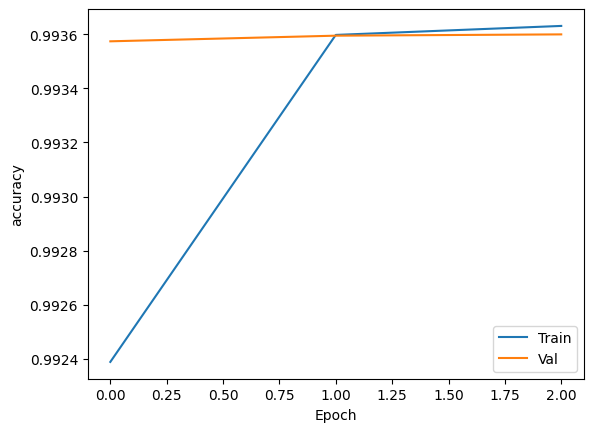

In [42]:
import matplotlib.pyplot as plt

plt.plot(final_history.history['accuracy'])
plt.plot(final_history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()

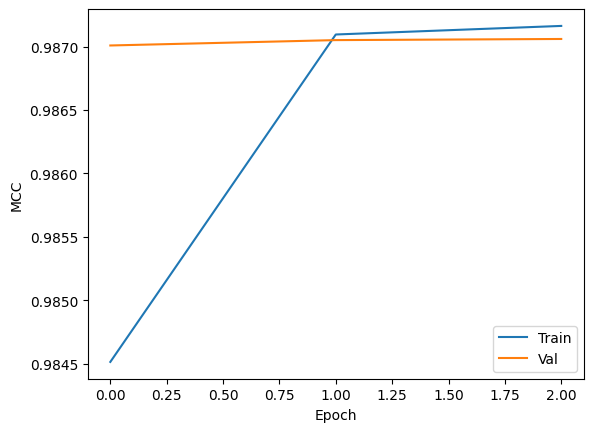

In [43]:
plt.plot(final_history.history['mcc_metric'])
plt.plot(final_history.history['val_mcc_metric'])
plt.ylabel('MCC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()

In [44]:
final_val = final_model.predict(val_pred)
final_val = (final_val >= 0.5) * 1

19481/19481 ━━━━━━━━━━━━━━━━━━━━ 11s 579us/step


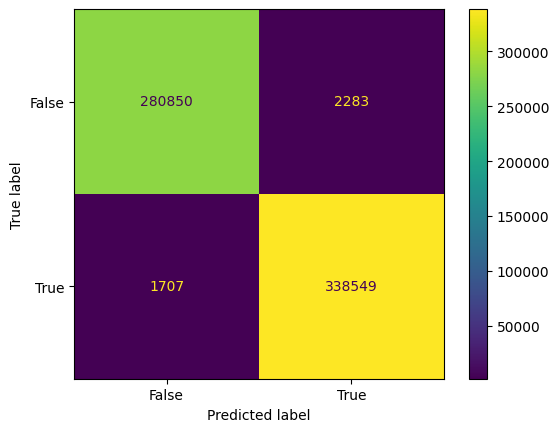

In [45]:
#This is just a function called a confusion matrix used to display the results.
from sklearn import metrics
def confusionMatrix(y, x):
    
    actual = y
    predicted = x


    confusion_matrix = metrics.confusion_matrix(predicted, actual)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot(values_format='.0f')
    plt.show()
confusionMatrix(y_val, final_val)

In [46]:
matthews_corrcoef(y_val, final_val)

0.9870901188924093

In [47]:
xgb_test_1 = xgb_list[0].predict(test_df)
xgb_test_2 = xgb_list[1].predict(test_df)
xgb_test_3 = xgb_list[2].predict(test_df)
xgb_test_4 = xgb_list[3].predict(test_df)
xgb_test_5 = xgb_list[4].predict(test_df)

lgbm_test_1 = lgb_list[0].predict(test_df)
lgbm_test_2 = lgb_list[1].predict(test_df)
lgbm_test_3 = lgb_list[2].predict(test_df)
lgbm_test_4 = lgb_list[3].predict(test_df)
lgbm_test_5 = lgb_list[4].predict(test_df)


test_pred = pd.DataFrame()
test_pred['xgb_1']=pd.Series(xgb_test_1)
test_pred['xgb_2']=pd.Series(xgb_test_2)
test_pred['xgb_3']=pd.Series(xgb_test_3)
test_pred['xgb_4']=pd.Series(xgb_test_4)
test_pred['xgb_5']=pd.Series(xgb_test_5)
test_pred['lgbm_1']=pd.Series(lgbm_test_1)
test_pred['lgbm_2']=pd.Series(lgbm_test_2)
test_pred['lgbm_3']=pd.Series(lgbm_test_3)
test_pred['lgbm_4']=pd.Series(lgbm_test_4)
test_pred['lgbm_5']=pd.Series(lgbm_test_5)

submission = final_model.predict(test_pred)

64937/64937 ━━━━━━━━━━━━━━━━━━━━ 58s 892us/step


In [49]:
outputs = []

for i in submission:
    if i < 0.5:
        outputs.append('e')
    else:
        outputs.append('p')

keys = pd.read_csv('./submission.csv')['id']

output = pd.DataFrame({'id': keys,'class': outputs})
output.to_csv('Soft_Voting_XGB_LGBM.csv', index=False)

output.head(20)

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
5,3116950,e
6,3116951,e
7,3116952,p
8,3116953,p
9,3116954,e
